# Topic Modeling Demo

Notebook from [Eric Elmoznino](https://github.com/EricElmoznino/lighthouse_nlp_II).


![workflow](images/topic_workflow.jpg)

# Loading the dataset

Dataset info [here](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset).

In [1]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

In [2]:
n_samples = 2000

newsgroups = fetch_20newsgroups(shuffle=True, random_state=27)
topic_names = newsgroups.target_names

X = newsgroups.data[:n_samples]
targets = [topic_names[target] for target in newsgroups.target][:n_samples]

# Save on computer memory by deleting large unsued variables
del newsgroups

print(f'Sample datapoint:\n{X[0]}')
print(f'Sample datapoint labeled topic: {targets[0]}')
print(f'\nTopic names:\n{topic_names}')

Sample datapoint:
From: brucek@Ingres.COM (Bruce Kleinman)
Subject: Re: Jewish Baseball Players?
Article-I.D.: pony.1993Apr15.223040.8733
Organization: Ingres Corporation, A subsidiary of The ASK Group, Inc.
Lines: 12

In article <15APR93.14691229.0062@lafibm.lafayette.edu> VB30@lafibm.lafayette.edu (VB30) writes:
>Just wondering.  A friend and I were talking the other day, and
>we were (for some reason) trying to come up with names of Jewish
>baseball players, past and present.  We weren't able to come up
>with much, except for Sandy Koufax, (somebody) Stankowitz, and
>maybe John Lowenstein.  Can anyone come up with any more.  I know
>it sounds pretty lame to be racking our brains over this, but
>humor us.  Thanks for your help.

Hank Greenberg, Sid Gordon, Ron Blomberg.

Guess it goes from the sublime to the ridiculous.

Sample datapoint labeled topic: rec.sport.baseball

Topic names:
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.ma

# Preprocessing to a numeric representation

#### "Normalizing" the text
We want our topic model to identify interesting and important patterns instead of noise. For that we need to "normalize" our text. Preprocessing is a crucial step when you do topic modeling and it markedly affects the results. For this example, let's use a popular Python NLP library called [spaCy](https://spacy.io/). It is a fast, easy-to-use, industrial-strength, and a powerful library. 

spaCy is a powerful library and it can do many other things, but we'll be using it for preprocessing.  With this library, you can run the NLP pipeline by simply calling the function `nlp`. You can then access information about each token in a `for` loop. 

```
doc = nlp(text)
for token in doc:
    print(token.pos_) #noun, verb, adj, etc.
    print(token.lemma_) #the lemma for the word
```

#### Create word frequency counts
The LDA model finds topics based on word frequencies, so you must use a `CountVectorizer` to create a Bag of Words representation of each document.

In [5]:
import re #regular expression
import spacy
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [7]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

def normalize_text(documents, 
                   min_token_len=2, 
                   irrelevant_pos=['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE']):
    """
    Given text, min_token_len, and irrelevant_pos carry out preprocessing of the text 
    and return a preprocessed string. 
    
    Keyword arguments:
    documents -- (np.array[str]) the list of documents to be preprocessed
    min_token_len -- (int) min_token_length required
    irrelevant_pos -- (list) a list of irrelevant pos tags
    
    Returns: np.array[str] the normalized documents
    """
    normalized_documents = []
    
    for text in documents:
        # Remove Emails
        text = re.sub(r'\S*@\S*\s?', '', text)

        # Remove extra space characters
        text = re.sub(r'\s+', ' ', text)

        # Remove distracting characters
        text = re.sub(r'''[\*\~]+''', "", text)

        doc = nlp(text) #covert text into spacy object
        clean_text = []

        for token in doc:
            if (token.is_stop == False # Check if it's not a stopword
                and token.is_alpha # Check if it's an alphanumerics char
                and len(token) > min_token_len # Check if the word meets minimum threshold
                and token.pos_ not in irrelevant_pos): # Check if the POS is in the acceptable POS tags
                lemma = token.lemma_ # Take the lemma of the word
                clean_text.append(lemma)
                
        clean_text = ' '.join(clean_text) #merge list of tokens back into string
        normalized_documents.append(clean_text) #append to list of normalized documents
        
    normalized_documents = np.array(normalized_documents) #convert list of normalized documents into numpy array
    return normalized_documents

# Create a Transformer from the function so that we can use it in a Pipeline
normalizer = FunctionTransformer(normalize_text)

# Show an example of the normalizer in action
print(f'Prior to normalization:\n{X[0]}')
print(f'After normalization:\n{normalizer.transform(X[0:1])}')

Prior to normalization:
From: brucek@Ingres.COM (Bruce Kleinman)
Subject: Re: Jewish Baseball Players?
Article-I.D.: pony.1993Apr15.223040.8733
Organization: Ingres Corporation, A subsidiary of The ASK Group, Inc.
Lines: 12

In article <15APR93.14691229.0062@lafibm.lafayette.edu> VB30@lafibm.lafayette.edu (VB30) writes:
>Just wondering.  A friend and I were talking the other day, and
>we were (for some reason) trying to come up with names of Jewish
>baseball players, past and present.  We weren't able to come up
>with much, except for Sandy Koufax, (somebody) Stankowitz, and
>maybe John Lowenstein.  Can anyone come up with any more.  I know
>it sounds pretty lame to be racking our brains over this, but
>humor us.  Thanks for your help.

Hank Greenberg, Sid Gordon, Ron Blomberg.

Guess it goes from the sublime to the ridiculous.

After normalization:
['Bruce Kleinman subject jewish Baseball Players Article organization Ingres Corporation subsidiary ASK Group line article write wonder fr

In [8]:
n_features = 5000

#keep 5000 most common tokens that appear in atleast 2 documents, less than 95% of documents
#notice binary=False by default
vectorizer = CountVectorizer(min_df=2, max_df=0.95, max_features=n_features)

In [9]:
preprocessor = Pipeline([('normalizer', normalizer), 
                         ('vectorizer', vectorizer)])

# Modeling

In [10]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import set_config

set_config(display='diagram')

In [11]:
n_topics = 10

#alpha = doc_topic_prior = 1 / n_components (every topic is equally likely in a document)
#eta = topic_word_prior = 1 / n_components (every word is equally likely in a topic)
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=5,
                                learning_method='online',
                                random_state=27)

pipeline = Pipeline([('preprocessor', preprocessor), 
                     ('model', lda)])
pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('normalizer',
                                  FunctionTransformer(func=<function normalize_text at 0x00000247121631C0>)),
                                 ('vectorizer',
                                  CountVectorizer(max_df=0.95,
                                                  max_features=5000,
                                                  min_df=2))])),
                ('model',
                 LatentDirichletAllocation(learning_method='online', max_iter=5,
                                           random_state=27))])

In [12]:
# Let's what the predictions look like for a datapoint.
# As discussed, we should get a probability distribution over n_topics
pipeline.transform(X[0:1])[0]

array([0.00238141, 0.14830256, 0.0023812 , 0.00238153, 0.00238125,
       0.80180683, 0.00238124, 0.03322136, 0.00238119, 0.00238143])

# Explore topics

After fitting LDA, we need to do some work to try and understand
what the fitted topics represent. 

One way to do this is to find out which are the most important words per topic. For this, we can look at the `lda.components_`
attribute, which is a `float` matrix of shape `(n_topics, n_words)` signifying each word's importance to a given topic.

We can also do this visualization with the convenient `pyLDAvis` package, which will also show us a low-dimensional representation of the topics so that we can see their relative similarities.

In [19]:
from matplotlib import pyplot as plt
import pyLDAvis#.sklearn
 
pyLDAvis.enable_notebook()

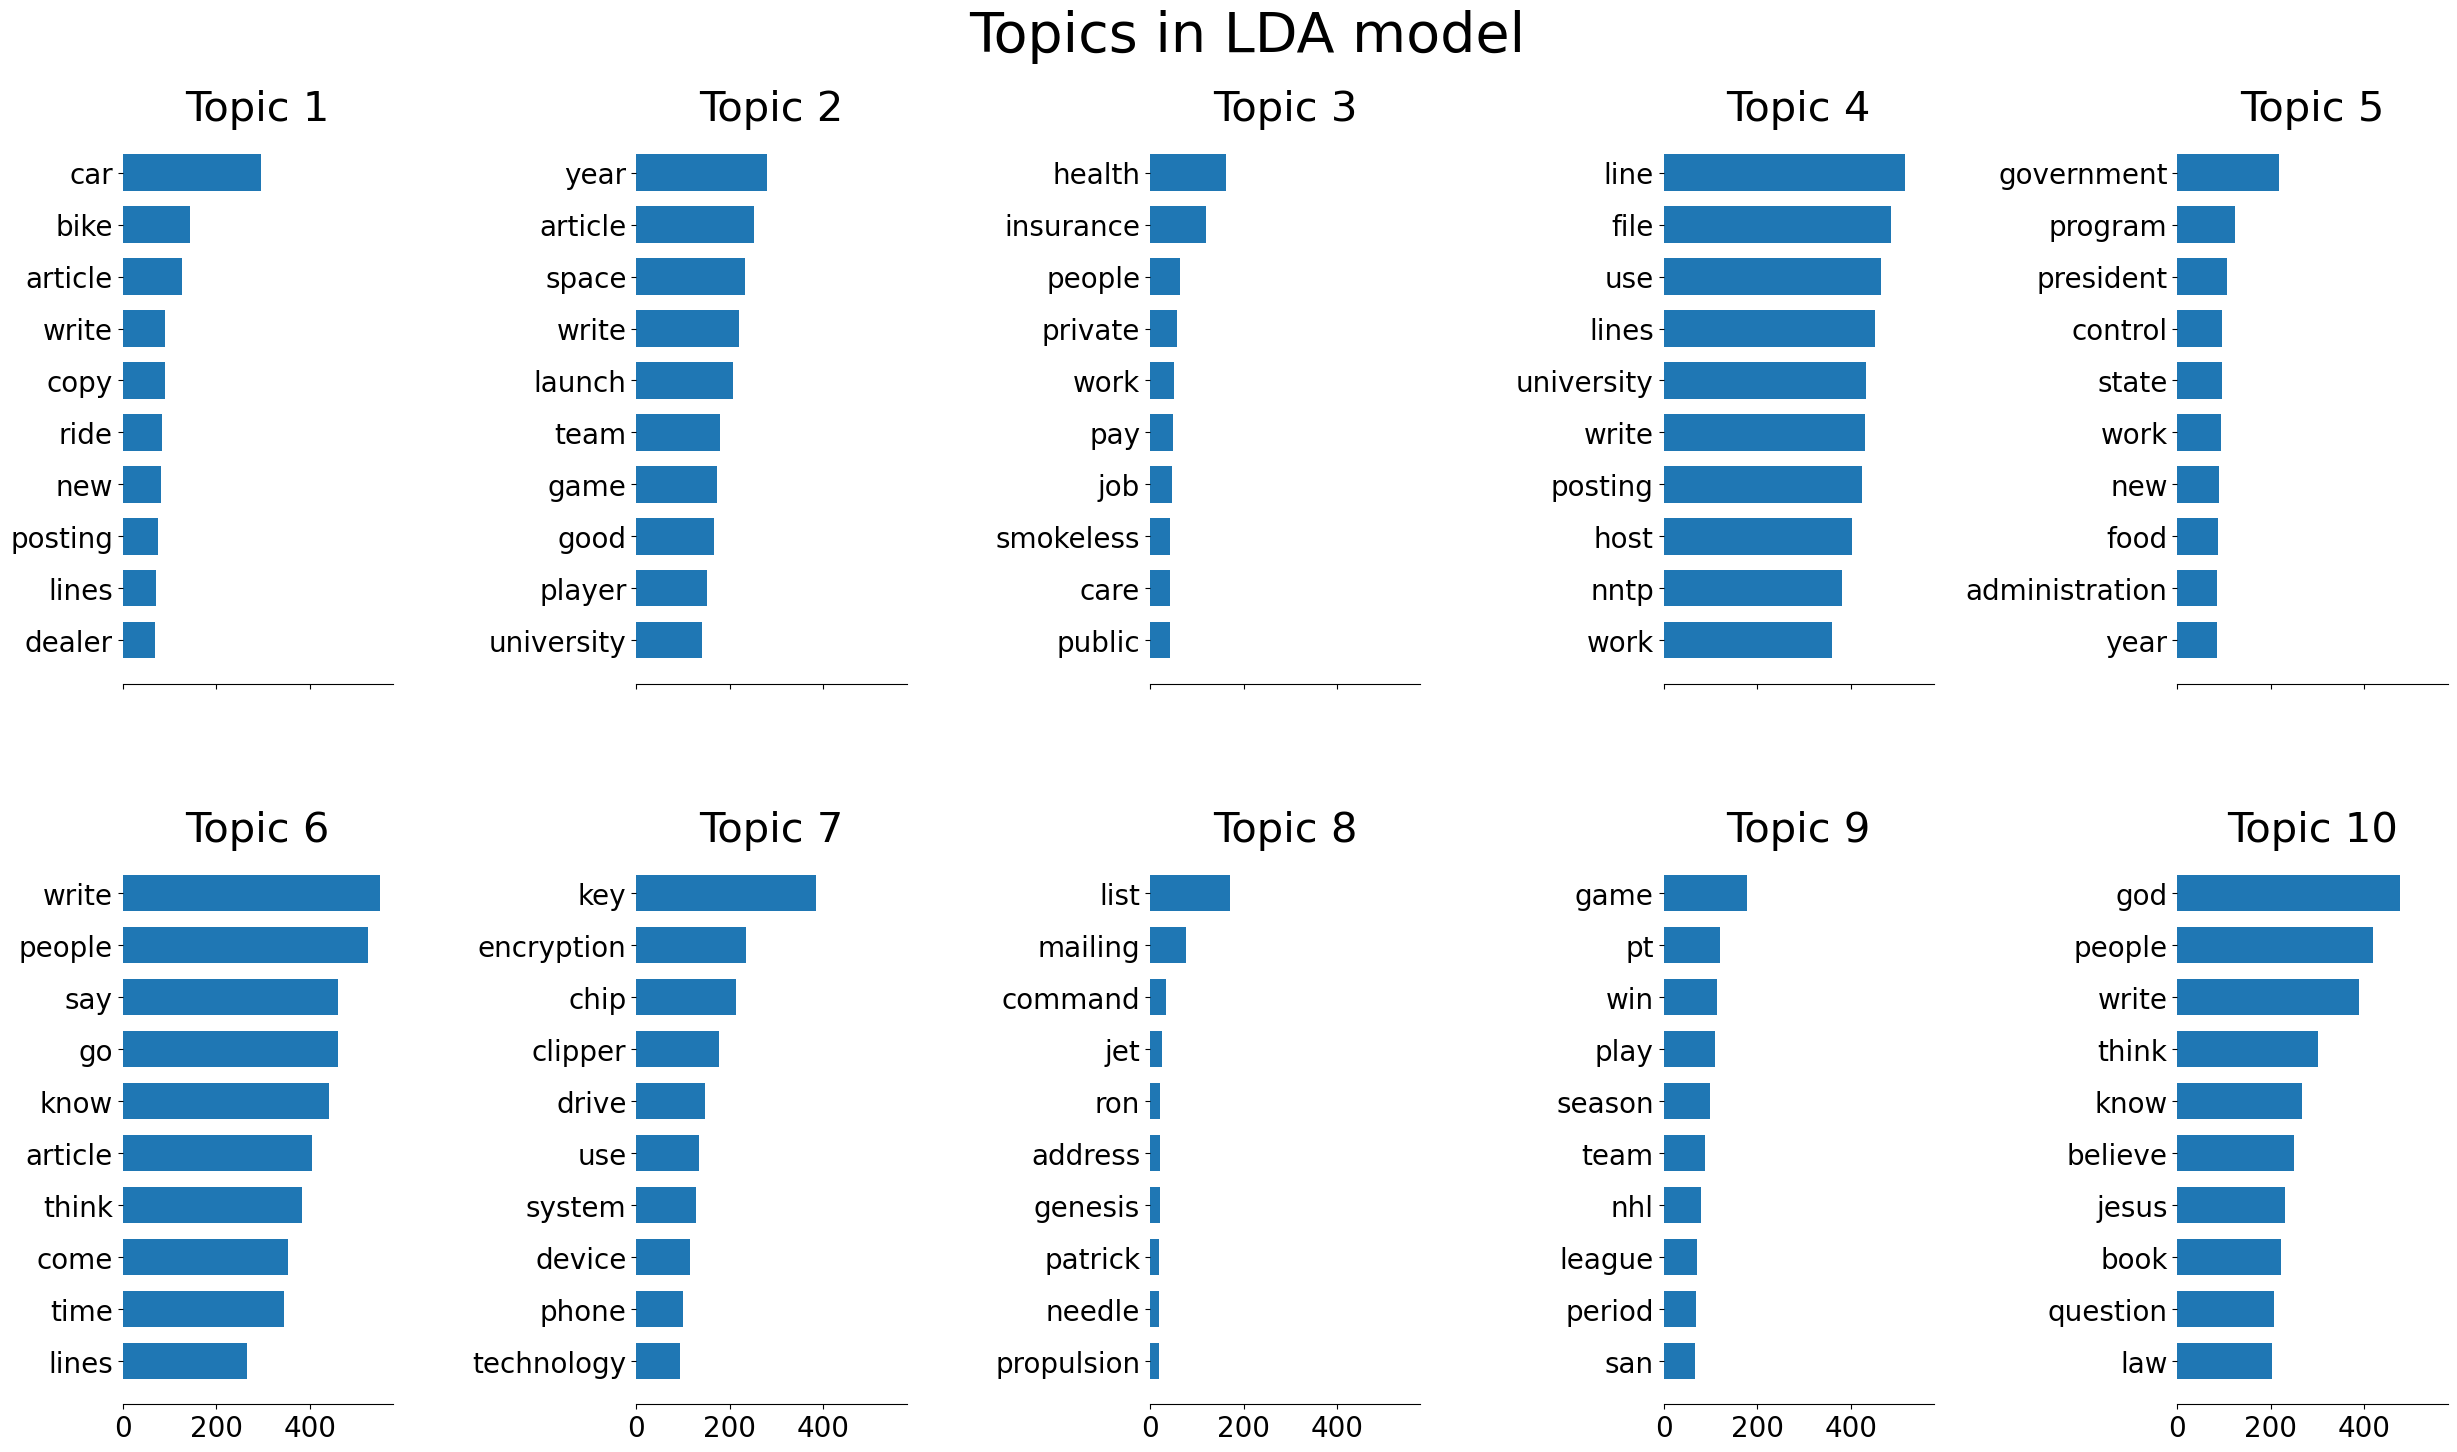

In [21]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
plot_top_words(lda, vectorizer.get_feature_names_out(), 10, 'Topics in LDA model')

In [27]:
# Get the feature names (terms) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Calculate the term frequency of each term in the dataset
term_frequency = data_vectorized.sum(axis=0).tolist()[0]

# Create a list of tuples containing the term and its frequency
vocab = [(term, freq) for term, freq in zip(feature_names, term_frequency)]

In [24]:
data_vectorized = preprocessor.transform(X)

In [35]:
#!pip install pyLDAvis==2.1.2

In [40]:
#vis = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
vis = pyLDAvis.prepare(lda, data_vectorized, vocab= vocab, term_frequency= term_frequency, mds='tsne')
vis

TypeError: prepare() missing 1 required positional argument: 'doc_lengths'

Left side:
- How similar topics are (in lower dimensional space)
- How popular the topics are
Right side:
- Saliency: how diagnositic each word is
- Word frequencies
Hovering:
- Right-side: which topics it is diagnostic of
- Left-side: conditional frequency of the words